# Deep Learning for NLP - Project

In [7]:
import io
import os
import numpy as np
import scipy

PATH_TO_DATA = "./data/"

class Word2vec():
    def __init__(self, fname, nmax=200000):
        self.load_wordvec(fname, nmax)
        self.word2id = {word: i for i, word in enumerate(self.word2vec.keys())} #edited because it was not working
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values())) #edited because it was not working
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        similar_words = []
        dict_scores = {self.score(w, vec2):vec2 for vec2 in self.word2vec.keys() }
        sorted_scores = sorted(dict_scores.keys())
        for k in range(2,K+2):
            score = sorted_scores[-k]
            similar_words.append((dict_scores[score],score))
        return similar_words

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        vec1, vec2 = self.word2vec[w1], self.word2vec[w2]
        return np.dot(vec1,vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        
        for sent in sentences:
            if idf is False:
                words_emb = [self.w2v.embeddings[self.w2v.word2id[word]] for word in sent.split() if word in self.w2v.word2id]
                if len(words_emb) != 0:
                    sentemb.append(np.mean(words_emb,axis=0))
            else:
                words_emb = [self.w2v.embeddings[self.w2v.word2id[word]]*idf[word] for word in sent.split() if word in self.w2v.word2id]
                if len(words_emb) != 0:
                    sentemb.append(np.mean(words_emb,axis=0))
        
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        similar_sentences = []
        dict_scores = {}
        for i,s2 in enumerate(sentences):
            dict_scores[self.score(s, s2)] = s2
        #dict_scores = {self.score(s, s2):s2 for s2 in sentences}
        sorted_scores = sorted(dict_scores.keys())
        for k in range(2,K+2):
            score = sorted_scores[-k]
            similar_sentences.append((dict_scores[score],score))
        return similar_sentences
        
    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        vec1 = self.encode([s1],idf).squeeze()
        vec2 = self.encode([s2],idf).squeeze()
        return np.dot(vec1,vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        
        for w in idf.keys():
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
            
        return idf
    
def load_sentences(location):
    sentences = []
    with io.open(location, encoding='utf-8') as f:
        for line in f:
            sentences.append(line.rstrip())
        return sentences

def isolate_class(sentences):
    data = []
    for i, line in enumerate(sentences):
        sentiment, sentence = line.split(' ', 1)
        data.append([sentence,sentiment])
    return data

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
# Download and load
# https://s3.amazonaws.com/senteval/others/crawl-300d-200k.vec

PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=200000):
        self.load_wordvec(fname, nmax)
        self.word2id = {word: i for i, word in enumerate(self.word2vec.keys())} #edited because it was not working
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values())) #edited because it was not working
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        similar_words = []
        dict_scores = {self.score(w, vec2):vec2 for vec2 in self.word2vec.keys() }
        sorted_scores = sorted(dict_scores.keys())
        for k in range(2,K+2):
            score = sorted_scores[-k]
            similar_words.append((dict_scores[score],score))
        return similar_words

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        vec1, vec2 = self.word2vec[w1], self.word2vec[w2]
        return np.dot(vec1,vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [12]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288558
germany berlin 0.7420295235998394
[('cats', 0.8353184714264993), ('kitty', 0.8034410478493814), ('kitten', 0.8024762062392743), ('feline', 0.768065407691186), ('kitties', 0.7237089223394708)]
[('dogs', 0.855207916336258), ('puppy', 0.784569427961543), ('Dog', 0.7511571638004245), ('doggie', 0.744241335717672), ('canine', 0.7421250622701407)]
[('dog', 0.855207916336258), ('pooches', 0.7712664737679777), ('Dogs', 0.7704396457434113), ('doggies', 0.7699192773615036), ('canines', 0.7527040042648147)]
[('france', 0.7775108541288558), ('Paris', 0.6845140397494098), ('parisian', 0.6786518975224022), ('london', 0.6728545431461277), ('berlin', 0.6424447628126261)]
[('austria', 0.7687671987529507), ('europe', 0.7597591231074469), ('german', 0.7445826305760618), ('berlin', 0.7420295235998394), ('poland', 0.723670565727986)]


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        
        for sent in sentences:
            if idf is False:
                words_emb = [self.w2v.embeddings[self.w2v.word2id[word]] for word in sent.split() if word in self.w2v.word2id]
                if len(words_emb) != 0:
                    sentemb.append(np.mean(words_emb,axis=0))
            else:
                words_emb = [self.w2v.embeddings[self.w2v.word2id[word]]*idf[word] for word in sent.split() if word in self.w2v.word2id]
                if len(words_emb) != 0:
                    sentemb.append(np.mean(words_emb,axis=0))
        
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        similar_sentences = []
        dict_scores = {}
        for i,s2 in enumerate(sentences):
            dict_scores[self.score(s, s2)] = s2
        #dict_scores = {self.score(s, s2):s2 for s2 in sentences}
        sorted_scores = sorted(dict_scores.keys())
        for k in range(2,K+2):
            score = sorted_scores[-k]
            similar_sentences.append((dict_scores[score],score))
        return similar_sentences
        
    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        vec1 = self.encode([s1],idf).squeeze()
        vec2 = self.encode([s2],idf).squeeze()
        return np.dot(vec1,vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        
        for w in idf.keys():
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
            
        return idf

In [14]:
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
def load_sentences(location):
    sentences = []
    with io.open(location, encoding='utf-8') as f:
        for line in f:
            sentences.append(line.rstrip())
        return sentences

sentences = load_sentences(os.path.join(PATH_TO_DATA, 'sentences.txt'))

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print(s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

idf = s2v.build_idf(sentences)
print(s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

[('an african american man smiling .', 0.9170453357707757), ('a little african american boy and girl looking up .', 0.8498556003875812), ('an afican american woman standing behind two small african american children .', 0.8217139139540895), ('an african american man is sitting .', 0.8207047384633509), ('a girl in black hat holding an african american baby .', 0.8191122491011851)]
0.5726258859719607
[('an african american man smiling .', 0.9170453357707757), ('a little african american boy and girl looking up .', 0.8498556003875812), ('an afican american woman standing behind two small african american children .', 0.8217139139540895), ('an african american man is sitting .', 0.8207047384633509), ('a girl in black hat holding an african american baby .', 0.8191122491011851)]
0.4751450875368782


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [47]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

fr_w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
en_w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [48]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

def identical_words(w2v1, w2v2):
    list1= list(w2v1.keys())
    list2= list(w2v2.keys())
    temp = set(list1) 
    intersection = [value for value in list2 if value in temp] 
    return intersection     

def get_matrix(w2v, w_list):
    X = np.zeros( (len(w_list), 300) )
    for i,word in enumerate(w_list):
        X[i,:] = w2v[word]
    return X
    
w_list = identical_words(fr_w2v.word2vec,en_w2v.word2vec)
X = get_matrix(fr_w2v.word2vec,w_list)
Y = get_matrix(en_w2v.word2vec,w_list)

In [ ]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

import scipy.linalg

def mapping(X,Y):
    U, S, V = scipy.linalg.svd(Y@X.T, full_matrices=True)
    return U@V.T

W = mapping(X,Y)

In [ ]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

Y_fr = W@X

# Get 5 random French words
index = np.random.randint(len(W), size=5)

def nearest_neighbors(index, fr_w2v, Y_fr, en_w2v, K=5):
    similar_words = {}
    for i in index:
        neighbors = []
        dict_scores = {score_emb(Y_fr[i],en_w2v.embeddings[en_w2v.word2id[w]]):w for w in en_w2v.word2vec.keys()}
        sorted_scores = sorted(dict_scores.keys())
        for k in range(1,K+1):
            score = sorted_scores[-k]
            neighbors.append([dict_scores[score],score])
        similar_words[fr_w2v.id2word[i]] = neighbors
    return similar_words
                               
def score_emb(vec1, vec2):
    return np.dot(vec1,vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                                                            
nearest_neighbors(index, fr_w2v, Y_fr, en_w2v, K=5)                      

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [6]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

PATH_TO_DATA = "./data"

def isolate_class(sentences):
    data = []
    for i, line in enumerate(sentences):
        sentiment, sentence = line.split(' ', 1)
        data.append([sentence,sentiment])
    return data

train = load_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev = load_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test = load_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))

train = isolate_class(train)
dev = isolate_class(dev)

In [7]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

def encoding(data, s2v):
    encoded = []
    for s_array in data:
        vec = s2v.encode([s_array[0]])
        encoded.append([vec, s_array[1]])
    return encoded
        
train_encoded = encoding(train,s2v)
dev_encoded = encoding(dev,s2v)
test_encoded = s2v.encode(test)

Loaded 200000 pretrained word vectors


In [20]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression

def split(data):
    X,y = np.zeros((len(data),300)), np.zeros(len(data))
    for i in range(len(data)):
        X[i] = data[i][0]
        y[i] = data[i][1]
    return X,y

X_train, y_train = split(train_encoded)
X_dev, y_dev = split(dev_encoded)

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

# y_train_pred = log_reg.predict(X_train)
# y_dev_pred = log_reg.predict(X_dev)

score_train = log_reg.score(X_train, y_train)
score_dev = log_reg.score(X_dev, y_dev)

print("accuracy on training set: ", score_train)
print("accuracy on dev set: ", score_dev)

accuracy on training set:  0.4911048689138577
accuracy on dev set:  0.4396003633060854


In [21]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

X_test = test_encoded
y_test = log_reg.predict(X_test)

with io.open('logreg_bov_y_test_sst.txt', 'w') as f:
    for y in y_test:
        f.write("%s\n" % y)

In [13]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=10)
xgb.fit(X_train,y_train)

X_test = test_encoded
y_test = xgb.predict(X_test)

with io.open('XGB_bov_y_test_sst.txt', 'w') as f:
    for y in y_test:
        f.write("%s\n" % y)

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [5]:
import keras

In [8]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

train = load_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev = load_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test = load_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))

train = isolate_class(train)
dev = isolate_class(dev)

In [9]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing.text import text_to_word_sequence, one_hot

def voc_size(*args):
    r = []
    for a in args:
        for w in a:
            if w not in r:
                r.append(w)
    return len(r)
        
def text_to_int(sentences, voc_size):
    num = []
    for s in sentences:
        num.append(one_hot(s, voc_size))
    return num

# isolating sentences list
train_sentences = np.array(train).T[0]
dev_sentences = np.array(dev).T[0]
test_sentences = test
    
n = voc_size(train_sentences,dev_sentences, test_sentences)

train_int = text_to_int(train_sentences, n)
dev_int = text_to_int(dev_sentences, n)
test_int = text_to_int(test_sentences, n)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [10]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing import sequence

def max_len(*args):
    result = 0
    for a in args:
        size = len(max(a,key=len))
        if size > result: result = size
    return result

maxlen = max_len(train_int,dev_int,test_int)

train_pad = sequence.pad_sequences(train_int,maxlen)
dev_pad = sequence.pad_sequences(dev_int,maxlen)
test_pad = sequence.pad_sequences(test_int,maxlen)

## 4.2 - Design and train your model

In [11]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Dropout

embed_dim  = maxlen  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5
ndrop = 0.4 # dropout
ndense = 64 # number of hidden units in the Dense layer

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid))
model.add(Dropout(ndrop))
model.add(Dense(ndense))
model.add(Dense(n_classes, activation='sigmoid'))

In [12]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 52)          615732    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29952     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 650,169
Trainable params: 650,169
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

from keras.utils import to_categorical
from keras.callbacks import Callback
import matplotlib.pyplot as plt

bs = 64
n_epochs = 6

X_train = train_pad
y_train = to_categorical(np.array(train).T[1]) 
X_dev = dev_pad
y_dev = to_categorical(np.array(dev).T[1])

class SaveEpoch(Callback):
    def __init__(self, logs={}):
        self.train_epoch = []
        self.dev_epoch = []
        self.loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_epoch.append(logs.get('acc'))
        self.dev_epoch.append(logs.get('val_acc'))   
        self.loss.append(logs.get('loss'))
    
save = SaveEpoch()

model.fit(X_train, y_train,
          batch_size=bs,
          nb_epoch=n_epochs,
          validation_data=(X_dev, y_dev),
          callbacks=[save])

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title('train & dev accuracy at each epoch')
ax1.plot(save.train_epoch, label='train')
ax1.plot(save.dev_epoch, label='dev')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_title('loss at each epoch')
ax2.plot(save.loss)
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 30s 3ms/step - loss: 1.5719 - acc: 0.2722 - val_loss: 1.5562 - val_acc: 0.2625
Epoch 2/6
8544/8544 [==============================] - 24s 3ms/step - loss: 1.4118 - acc: 0.3844 - val_loss: 1.3952 - val_acc: 0.3815
Epoch 3/6
8544/8544 [==============================] - 24s 3ms/step - loss: 1.1194 - acc: 0.5073 - val_loss: 1.5299 - val_acc: 0.3651
Epoch 4/6
8544/8544 [==============================] - 24s 3ms/step - loss: 0.8852 - acc: 0.6234 - val_loss: 1.8273 - val_acc: 0.3542
Epoch 5/6
8544/8544 [==============================] - 25s 3ms/step - loss: 0.6761 - acc: 0.7303 - val_loss: 2.1630 - val_acc: 0.3488
Epoch 6/6
8544/8544 [==============================] - 25s 3ms/step - loss: 0.5365 - acc: 0.8001 - val_loss: 2.3858 - val_acc: 0.3261


Text(0,0.5,'loss')

In [15]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

X_test = test_pad
y_test_pred = model.predict(X_test)

with io.open('logreg_lstm_y_test_sst.txt', 'w') as f:
    for y in y_test_pred:
        f.write("%s\n" % y)
    print('prediction saved')

prediction saved


## 4.3 -- innovate !

In [16]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# preprocessing: embedding of the data with our previous w2v model
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

def new_encoding(sentences, w2v, idf=False):
    encoding = []    
    for sent in sentences:
        sentemb = []
        if idf is False:
            words_emb = [w2v.embeddings[w2v.word2id[word]] for word in sent.split() if word in w2v.word2id]
            if len(words_emb) != 0:
                sentemb = words_emb
        else:
            words_emb = [w2v.embeddings[w2v.word2id[word]]*idf[word] for word in sent.split() if word in w2v.word2id]
            if len(words_emb) != 0:
                sentemb = words_emb
        encoding.append(sentemb)
    return encoding

def new_padding(sentences, maxlen):
    padded = np.zeros(( len(sentences), maxlen, len(sentences[0][0]) ))
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentences[i]):
            padded[i][j][:] = word
    return padded
    
train_encoded = new_encoding(np.array(train).T[0],w2v)
dev_encoded = new_encoding(np.array(dev).T[0],w2v)
test_encoded = new_encoding(test,w2v)

maxlen = max_len(train_encoded,dev_encoded,test_encoded)

train_pad = new_padding(train_encoded,maxlen)
dev_pad = new_padding(dev_encoded,maxlen)
test_pad = new_padding(test_encoded,maxlen)

Loaded 200000 pretrained word vectors


In [41]:
# encoder design: add convolutions

from keras.layers import Conv1D, MaxPooling1D

emb_dim  = maxlen  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
emb_size = 300  # size of the embedded word vector
n_classes  = 5
ndrop = 0.4 # dropout
ndense = 64 # number of hidden units in the first Dense layer
nconv = 64 # number of filters in the Conv layer
sconv = 3 # size of convolution filter
pool_size = 2 # pooling size

model = Sequential()
model.add(Conv1D(nconv, sconv, activation = 'relu', input_shape = (emb_dim,emb_size)))
model.add(Conv1D(nconv, sconv, activation = 'relu', input_shape = (emb_dim,emb_size)))
model.add(LSTM(nhid))
model.add(Dropout(ndrop))
model.add(Dense(ndense))
model.add(Dense(n_classes, activation='sigmoid'))

In [42]:
# compilation

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 54, 64)            57664     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 52, 64)            12352     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
Total params: 107,525
Trainable params: 107,525
Non-trainable params: 0
_________________________________________________________________
None

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 34s 4ms/step - loss: 1.5745 - acc: 0.2674 - val_loss: 1.5730 - val_acc: 0.2634
Epoch 2/6
8544/8544 [==============================] - 28s 3ms/step - loss: 1.5673 - acc: 0.2671 - val_loss: 1.5582 - val_acc: 0.2643
Epoch 3/6
8544/8544 [==============================] - 29s 3ms/step - loss: 1.4859 - acc: 0.3521 - val_loss: 1.3958 - val_acc: 0.3742
Epoch 4/6
8544/8544 [==============================] - 29s 3ms/step - loss: 1.4009 - acc: 0.3933 - val_loss: 1.3766 - val_acc: 0.3678
Epoch 5/6
8544/8544 [==============================] - 29s 3ms/step - loss: 1.3406 - acc: 0.4034 - val_loss: 1.3085 - val_acc: 0.3851
Epoch 6/6
8544/8544 [==============================] - 28s 3ms/step - loss: 1.2644 - acc: 0.4232 - val_loss: 1.2987 - val_acc: 0.3933


Text(0,0.5,'loss')

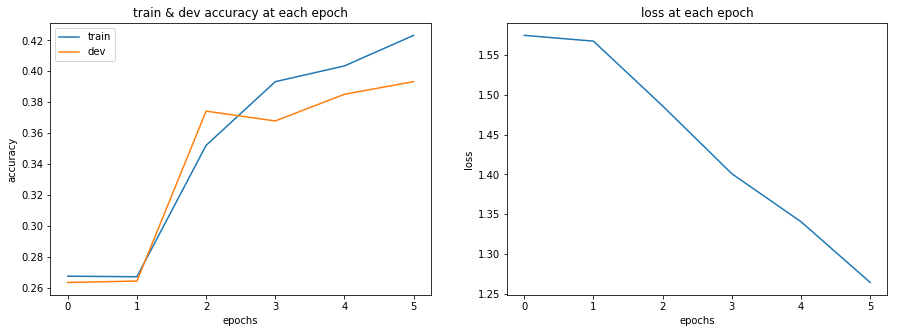

In [43]:
# training

bs = 64
n_epochs = 6

X_train = train_pad
y_train = to_categorical(np.array(train).T[1]) 
X_dev = dev_pad
y_dev = to_categorical(np.array(dev).T[1])
    
save = SaveEpoch()

model.fit(X_train, y_train,
          batch_size=bs,
          nb_epoch=n_epochs,
          validation_data=(X_dev, y_dev),
          callbacks=[save])

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title('train & dev accuracy at each epoch')
ax1.plot(save.train_epoch, label='train')
ax1.plot(save.dev_epoch, label='dev')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_title('loss at each epoch')
ax2.plot(save.loss)
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')

In [44]:
# Generating predictions 

X_test = test_pad
y_test_pred = model.predict(X_test)

with io.open('logreg_conv_y_test_sst.txt', 'w') as f:
    for y in y_test_pred:
        f.write("%s\n" % y)
    print('prediction saved')

prediction saved
